## Building a Robot Judge
### Problem Set 2

In [37]:
#*************#
#   imports   #
#*************#

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gensim.models.ldamodel import LdaModel

from keras.layers import Input, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from math import exp

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import ElasticNet, LogisticRegression

In [2]:
#************************************************************#
#   create 'master' data set, which contains all metadatas   #
#************************************************************#
cases = pd.read_csv("case_metadata.csv")
cases = cases.set_index('caseid').T.to_dict('list')

# load frequencies (created in problem set 1)
dataSet = np.load("dataSet.npy")

caseIds = dataSet[:, 0].tolist()
frequencies = dataSet[:, 1:-1].tolist()

for i, case in enumerate(caseIds):
    cases[case].append(frequencies[i])
    
# cases is organized as follows: {caseid : [case_reversed, judge_id, year, log_cites, frequency]}
dic = {'case_reversed':0, 'judge_id':1, 'year':2, 'log_cites':3, 'frequency':4}

### 1.

In [2]:
####################################################################################################
#                                                                                                  #
# Take your best-performing logistic regression model from Problem Set 1 (or train a new one).     #
# Use cross_val_predict() to form model predictions for each observation. Construct a confusion    #
# matrix for the predictions. Report the precision_recall_curve() and roc_curve(). Make a          #
# calibration plot (as in Bansak et al 2018, appendix page 24).                                    #
#                                                                                                  #
####################################################################################################

In [3]:
#********************************************#
#   create set and split in train and test   #
#********************************************#
frequencies = []
reverses = []

for case in caseIds:
    freq = cases[case][dic['frequency']:]
    if len(freq) > 0:
        frequencies.append(freq[0])
        reverses.append(cases[case][dic['case_reversed']])

trainX = np.array(frequencies)
trainY = np.array(reverses)

trainX = trainX[: int(len(trainX) * 0.9)]
trainY = trainY[: int(len(trainY) * 0.9)]

testX = trainX[int(len(trainX) * 0.9) :]
testY = trainY[int(len(trainY) * 0.9) :]

In [5]:
#**********************************************************#
#   train logistic regression model to predict reversal    #
#**********************************************************#
x = Input((trainX.shape[1],))
y = Dense(1, activation="sigmoid")(x)

model = Model(x, y)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

model.summary()

# train model
history = model.fit(x=trainX, y=trainY, batch_size=16, epochs=5,
                    validation_split=0.2)
# test model
accuracy = model.evaluate(testX, testY, batch_size=16)

print("training accuracy:", history.history['val_acc'][-1])
print("test accuracy:", accuracy[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 227981)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 227982    
Total params: 227,982
Trainable params: 227,982
Non-trainable params: 0
_________________________________________________________________
Train on 360 samples, validate on 90 samples
Epoch 1/5
360/360 [==============================] - 54s 149ms/step - loss: 0.2870 - acc: 0.5889 - val_loss: 0.3049 - val_acc: 0.5778
Epoch 2/5
360/360 [==============================] - 46s 126ms/step - loss: 0.0082 - acc: 0.9944 - val_loss: 0.3065 - val_acc: 0.6222
Epoch 3/5
360/360 [==============================] - 45s 124ms/step - loss: 0.0064 - acc: 0.9944 - val_loss: 0.3070 - val_acc: 0.6222
Epoch 4/5
360/360 [==============================] - 45s 124ms/step - loss: 0.0057 - 

In [6]:
#****************************************#
#   form model predictions with model    #
#****************************************#
#yPred = cross_val_predict(model, testX.reshape(-1, 1), testY.reshape(-1, 1))

yScores = model.predict(testX).ravel()
yPred = (yScores > 0.5).astype(np.int)    # convert to int
yTrue = [int(testY[i]) for i in range(len(testY))]

In [7]:
#******************************#
#   create confusion matrix    #
#******************************#
matrix = confusion_matrix(testY.reshape(-1, 1), yPred.reshape(-1, 1))

print(matrix)

[[ 1 14]
 [ 3 27]]


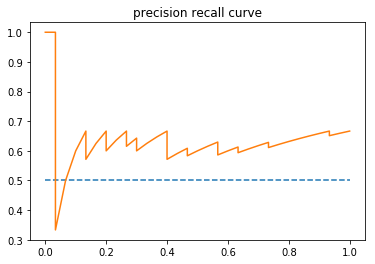

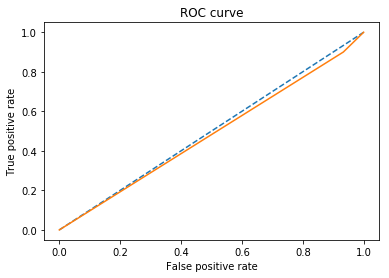

In [8]:
#***********************************************#
#   report the precision recall and roc curve   #
#***********************************************#
precision, recall, thresholds = precision_recall_curve(yTrue, yScores)
fpr, tpr, thresholds = roc_curve(yTrue, yPred, pos_label=1)

# precision recall curve
plt.figure()
plt.plot([0, 1], [0.5, 0.5], linestyle='--')   # plot no skill
plt.plot(recall, precision)
plt.title('precision recall curve')
plt.show()

# roc curve
# TODO: why weird? maybe freq...
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()


# TODO: calibration plot

### 2.

In [ ]:
####################################################################################################
#                                                                                                  #
# Scale your n-gram frequencies while maintaining sparsity, as discussed in class. Train an        #
# elastic net model to predict log citations to a case (log_cites). Run cross_val_predict() to     #
# form model predictions and report a scatter plot of true and predicted values.                   #
#                                                                                                  #
####################################################################################################

In [ ]:
#*******************************************************#
#   scale your n-gram frequencies (maintain sparsity)   #
#*******************************************************#

# Not sure what to do here...
# The frequencies are already normalized and standardize (while maintain sparsity 
# by not taking out the mean).

In [10]:
#********************************************#
#   create set and split in train and test   #
#********************************************#
logCites = []
eNetFreq = []

for case in caseIds:
    logCite = cases[case][dic['log_cites']]
    freq = cases[case][dic['frequency']:]
    
    # remove nan entries
    if str(logCite) != 'nan' and len(freq) > 0:
        eNetFreq.append(freq[0])
        logCites.append(logCite)

trainX = np.array(eNetFreq)
trainY = np.array(logCites)

trainX = trainX[: int(len(trainX) * 0.9)]
trainY = trainY[: int(len(trainY) * 0.9)]

testX = trainX[int(len(trainX) * 0.9) :]
testY = trainY[int(len(trainY) * 0.9) :]

In [14]:
#*********************************************************#
#   train an elastic net model to predict log citations   #
#*********************************************************#
elasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticNet.fit(trainX, trainY)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

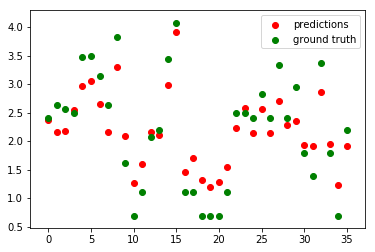

In [28]:
#******************************************************#
#   form model predictions and report a scatter plot   #
#******************************************************#
preds = elasticNet.predict(testX.astype('float'))

plt.scatter(range(len(preds)), preds, c='r', label='predictions')
plt.scatter(range(len(testY)), testY, c='g', label='ground truth')
plt.legend(loc='upper right')
plt.show()

### 3.

In [ ]:
####################################################################################################
#                                                                                                  #
# Use the judge identifiers (judge_id) to produce the average citations to cases for each judge.   #
# Then estimate a two-stage least-squares model with Z as average citations of the judge, X as     #
# citations to the case, and Y as whether the case was reversed. Include year fixed effects.       #
# Report estimates for coefficient and standard error on X.                                        #
#                                                                                                  #
####################################################################################################

In [29]:
#***********************************************************#
#   produce the average citations to cases for each judge   #
#***********************************************************#
avgCitJudge = {cases[case][dic['judge_id']] : [] for case in caseIds 
               if str(cases[case][dic['judge_id']]) != 'nan'}

# sum up all log cites of each judge
for case in caseIds:
    logCite = cases[case][dic['log_cites']]
    
    # remove nan entries
    if str(logCite) != 'nan':
        avgCitJudge[cases[case][dic['judge_id']]].append(logCite)


# calculate average citations to cases for each judge
for key, value in copy.copy(avgCitJudge).items():
    
    # remove judges with no cites
    if len(value) == 0:
        del avgCitJudge[key]
    else:
        # log_cites, log(1 + citations that a case received from other courts)
        avgCitJudge[key] = np.mean([exp(elem) - 1 for elem in value])

In [ ]:
#**********************************************#
#   estimate a two-stage least-squares model   #
#**********************************************#

### 4.

In [ ]:
####################################################################################################
#                                                                                                  #
# Train LDA on the cases. Produce word clouds for the topics. Inspect the word clouds for          #
# different models to decide on the right number of topics.                                        #
#                                                                                                  #
####################################################################################################

In [43]:
#*********************************************#
#   train Latent Dirichlet Allocation (LDA)   #
#*********************************************#
lda = LdaModel(, num_topics=10, id2word=dictionary, passes=3)
lda.show_topics(formatted=False)

SyntaxError: invalid syntax (<ipython-input-43-c048e5b21553>, line 4)

### 5.

In [ ]:
####################################################################################################
#                                                                                                  #
# Replicate your sklearn logistic regression model (no hidden layers, L2 regularization, and       #
# softmax output layer) in Keras or some other deep learning library. Compare performance.         #
# Now add two hidden layers, dropout, and batch normalization. Compare performance.                #
#                                                                                                  #
####################################################################################################

In [32]:
# I am not sure which model is ment here, but I'll assume, the LogisticRegression model 
# to predict reversal.

frequencies = []
reverses = []

for case in caseIds:
    freq = cases[case][dic['frequency']:]
    if len(freq) > 0:
        frequencies.append(freq[0])
        reverses.append(cases[case][dic['case_reversed']])

trainX = np.array(frequencies)
trainY = np.array(reverses)

trainX = trainX[: int(len(trainX) * 0.9)]
trainY = trainY[: int(len(trainY) * 0.9)]

testX = trainX[int(len(trainX) * 0.9) :]
testY = trainY[int(len(trainY) * 0.9) :]

In [45]:
print("test accuracy model:", accuracy[1])

# As I already used Keras in the tasks before, I will now use the sklearn logistic regression
# model and compare it with my Keras model. Then I will add (to the Keras model) two hidden layers, 
# dropout, and batch normalization and compare again.

#*******************#
#   sklearn model   #
#*******************#
sklearnModel = LogisticRegression()
sklearnModel.fit(trainX, trainY)

predY = sklearnModel.predict(testX.astype('float'))

# test accuracy
sklearnAcc = accuracy_score(testY, predY)

print("test accuracy sklearn model:", sklearnAcc)

test accuracy model: 0.6222222288449605


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


test accuracy sklearn model: 1.0


In [44]:
#************************#
#   better Keras model   #
#************************#
x = Input((trainX.shape[1],))
y = Dense(100, activation="relu")(x)
y = Dropout(0.1)(y)
y = Dense(100, activation="relu")(y)
y = BatchNormalization()(y)
y = Dropout(0.1)(y)
y = Dense(1, activation="sigmoid")(y)

betterModel = Model(x, y)
betterModel.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# train model
history = betterModel.fit(x=trainX, y=trainY, batch_size=16, epochs=5, validation_split=0.2)

# test model
betterAcc = betterModel.evaluate(testX, testY, batch_size=16)

print("test accuracy better model:", betterAcc[1])

Train on 360 samples, validate on 90 samples
Epoch 1/5
360/360 [==============================] - 64s 176ms/step - loss: 0.3088 - acc: 0.4917 - val_loss: 0.2695 - val_acc: 0.6111
Epoch 2/5
360/360 [==============================] - 54s 149ms/step - loss: 0.1328 - acc: 0.8167 - val_loss: 0.2192 - val_acc: 0.6889
Epoch 3/5
360/360 [==============================] - 52s 146ms/step - loss: 0.1016 - acc: 0.8639 - val_loss: 0.2225 - val_acc: 0.6889
Epoch 4/5
360/360 [==============================] - 50s 138ms/step - loss: 0.0801 - acc: 0.9194 - val_loss: 0.2211 - val_acc: 0.6889
Epoch 5/5
45/45 [==============================] - 4s 99ms/step
0.6666666719648573
